# Official Manify tutorial

This tutorial will cover the core functionality available in Manify. We have tried to make each of the sections as 
self-contained as possible (at least when it comes to running the actual code), so feel free to skip around or do the
entire thing end-to-end!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

import manify
import manify.utils as utils

## Manifold classes

Manify provides two manifold classes: `Manifold` and `ProductManifold`. The former is a base class for single 
constant-curvature Riemannian manifolds, such as spheres, hyperbolic spaces, and Euclidean spaces. The latter is the
Cartesian product of multiple individual manifolds.

All manifolds implement the following methods:
* `to`: Change device, as you would in PyTorch.
* `inner`: Inner product
* `dist`: Distance between two (sets of) points
* `dist2`: Squared distance between two (sets of) points
* `pdist`: Pairwise distance between a set of points
* `pdist2`: Pairwise squared distance between a set of points
* `sample`: Sample points from a Wrapped Normal distribution on the manifold
* `log_likelihood`: Compute the log-likelihood of a set of points under a Wrapped Normal distribution on the manifold
* `logmap`: Logarithmic map from the manifold to its tangent space at a point
* `expmap`: Exponential map from the tangent space at a point to the manifold
* `stereographic`: Converts the manifold, and any points you pass to this method, to its stereographic equivalent
* `inverse_stereographic`: Converts the stereographic coordinates back to the manifold coordinates
* `apply`: Apply any function to the manifold by composing it with the manifold's `logmap` and `expmap` methods

Let's begin by looking at the individual manifold classes, and the various methods they provide. Let's start with a
single hyperbolic manifold:

### Basic `Manifold` usage

In [3]:
hyperbolic_manifold = manify.Manifold(curvature=-1.0, dim=2)

Of course, manifolds aren't very interesting without some points on them, so let's use the built-in `sample` method to
generate some random points from a wrapped normal distribution on the manifold.

In [4]:
hyperbolic_points = hyperbolic_manifold.sample(n_samples=100)
print(f"Sampled points shape: {hyperbolic_points.shape}")

Sampled points shape: torch.Size([100, 3])


Since our maniold is 2-dimensional, we can theoretically visualize it in 2 dimensions. However, by default it's in the
Loretnz model of hyperbolic space, which actually uses 3 ambient dimensions. We can use the manifold's `stereographic`
method to convert to the Poincaré disk model so that we can visualize it:

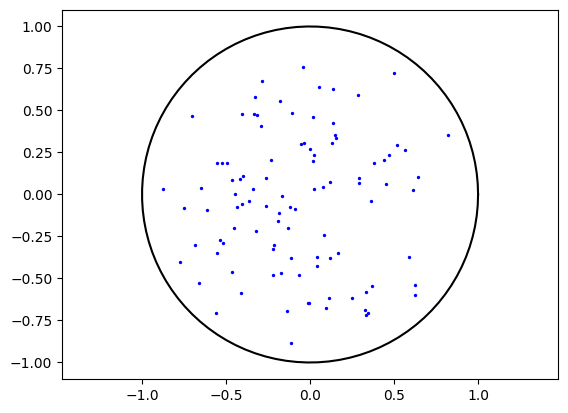

In [5]:
poincare_manifold, poincare_points = hyperbolic_manifold.stereographic(hyperbolic_points)

plt.scatter(poincare_points[:, 0].detach().numpy(), poincare_points[:, 1].detach().numpy(), color="blue", s=2)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.show()

Manify implements `dist` methods we can use to compute distances between two points on the manifold. They broadcast in
the same way as you might expect in PyTorch (or your favorite tensor library):

In [6]:
hyperbolic_dists = hyperbolic_manifold.dist(hyperbolic_points[:8], hyperbolic_points[-4:])
hyperbolic_dists

tensor([[0.8200, 1.4662, 0.8532, 1.6556],
        [1.9681, 1.4222, 1.3137, 2.5931],
        [2.3607, 2.4767, 1.9274, 2.8000],
        [1.7646, 1.8307, 1.6079, 2.6071],
        [1.4451, 2.2593, 1.6616, 2.1926],
        [1.6389, 0.4563, 0.9073, 2.3861],
        [2.1264, 1.4532, 1.4530, 2.7674],
        [0.9306, 1.4148, 0.8832, 1.7727]], grad_fn=<MulBackward0>)

Notice that if we do the same thing with the Poincaré disk model, we get the same result. This is because the two models
are isometric (i.e. they preserve distances). This is also true for the sphere and stereographic sphere.

In [7]:
poincare_dists = poincare_manifold.dist(poincare_points[:8], poincare_points[-4:])
print(f"Total absolute deviation between distances: {(hyperbolic_dists - poincare_dists).abs().sum()}")
poincare_dists

Total absolute deviation between distances: 5.066394805908203e-06


tensor([[0.8200, 1.4662, 0.8532, 1.6556],
        [1.9681, 1.4222, 1.3137, 2.5931],
        [2.3607, 2.4767, 1.9274, 2.8000],
        [1.7646, 1.8307, 1.6079, 2.6071],
        [1.4451, 2.2593, 1.6616, 2.1926],
        [1.6389, 0.4563, 0.9073, 2.3861],
        [2.1264, 1.4532, 1.4530, 2.7674],
        [0.9306, 1.4148, 0.8832, 1.7727]], grad_fn=<MulBackward1>)

Note that each manifold is equipped with a `manifold` attribute, which is a reference to its base Geoopt class. So for
instance, if we prefer to use the `random_normal` method there (which is implemented for this particular manifold),
we can do so like this:

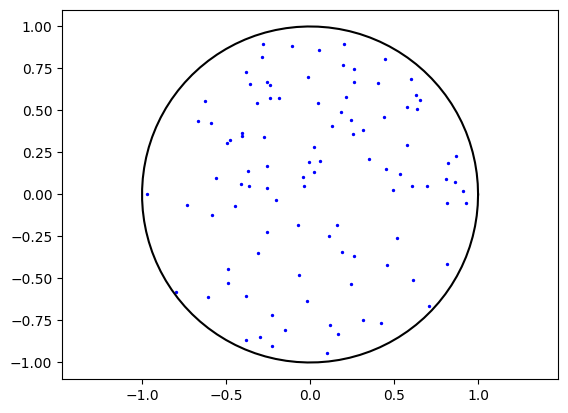

In [8]:
poincare_points_geoopt = poincare_manifold.manifold.random_normal((100, 2))

plt.scatter(
    poincare_points_geoopt[:, 0].detach().numpy(), poincare_points_geoopt[:, 1].detach().numpy(), s=2, color="blue"
)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.show()

### Product manifolds

Probably the reason you're here is because you want to work with product manifolds, since the basic manifold classes
are available in a number of other popular libraries. The `ProductManifold` class is initialized with a **signature**,
which is a list of (curvature, dimension) tuples. The curvature can be any float, and the dimension any integer. So
for instance, the signature `[(1.0, 2), (0.0, 3), (-1.0, 4)]` would create a product manifold with a 2D sphere,
a 3D Euclidean space, and a 4D hyperbolic space.

In addition the all of the methods available in the `Manifold` class, the `ProductManifold` class also provides a few other methods:
* `parameters`: Returns a list of all scale factors (think curvatures) for each of the manifolds in the product; useful in learnable-curvature settings
* `factorize`: Factorizes a set of points on the product manifold into a list of points on each of the individual manifolds
* `gaussian_mixture`: Samples points from a Gaussian mixture model on the product manifold, useful for benchmarking classifiers and regressors

Let's take a look at the latter two methods in action using the signature we suggested above.

In [9]:
product_manifold = manify.ProductManifold(signature=[(1.0, 2), (0.0, 3), (-1.0, 4)])

If we sample some points from this manifold, we'll find that they have $(2+ 1) + (3) + (4 + 1) = 11$ dimensions: all
non-Euclidean manifolds have an extra ambient dimension, whereas Euclidean manifolds (curvature 0) do not.

In [10]:
product_points = product_manifold.sample(n_samples=1000)
print(f"Sampled points shape: {product_points.shape}")

Sampled points shape: torch.Size([1000, 11])


If you would like to work with each component manifold's coordinates separately, the `factorize` method will return a
list of tensors in each manifold's coordinates:

In [11]:
product_points_factorized = product_manifold.factorize(X=product_points)
print(f"Factorized points shape: {[p.shape for p in product_points_factorized]}")

Factorized points shape: [torch.Size([1000, 3]), torch.Size([1000, 3]), torch.Size([1000, 5])]


The product manifold class has a lot of structure to help map between the different component manifolds and embeddings.
To make matters worse, sometimes we need to deal with *intrinsic* dimensions as well (e.g. when sampling covariance) 
matrices!

Here we will print out some of the attributes that help with this bookkeeping.

The `projection_matrix` attribute is especially nice, as right-multiplying a sample by this will add zeros in all of the
ambient dimensions for each component manifold - effectively turning a Gaussian sample into an element of the product
manifold's tangent plane at the origin! We make extensive use of this in all of our sampling methods.

dim2man (Ambient dimension -> Manifold mapping): {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2}
man2dim (Manifold -> Ambient dimension mapping): {0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7, 8, 9, 10]}
man2intrinsic (Manifold -> Intrinsic dimension mapping): {0: [0, 1], 1: [2, 3, 4], 2: [5, 6, 7, 8]}
man2intrinsic (Manifold -> Ambient dimension mapping): {0: [0, 1], 1: [2, 3, 4], 2: [5, 6, 7, 8]}


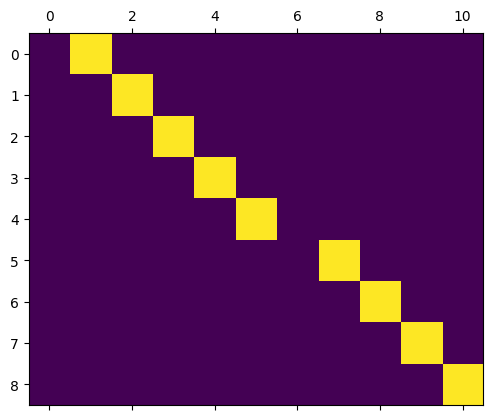

In [12]:
print(f"dim2man (Ambient dimension -> Manifold mapping): {product_manifold.dim2man}")
print(f"man2dim (Manifold -> Ambient dimension mapping): {product_manifold.man2dim}")
print(f"man2intrinsic (Manifold -> Intrinsic dimension mapping): {product_manifold.man2intrinsic}")
print(f"man2intrinsic (Manifold -> Ambient dimension mapping): {product_manifold.man2intrinsic}")

plt.matshow(product_manifold.projection_matrix.numpy())
plt.show()

Note that the `P` attribute contains pointers to each of the individual manifolds:

In [13]:
print(product_manifold.P)

[<manify.manifolds.Manifold object at 0x33ec82b10>, <manify.manifolds.Manifold object at 0x33acbb590>, <manify.manifolds.Manifold object at 0x33ad72d80>]


Notice, additionally, that nothing is stopping us from having a single component in our signature. This essentially
means that you can always use the `ProductManifold` class, which in fact is what we recommend you do.

In [14]:
hyperbolic_pseudoproduct_manifold = manify.ProductManifold(signature=[(-1.0, 2)])

One neat thing that the `ProductManifold` class supports is sampling from Gaussian mixtures. This is really useful if
you want to benchmark some classifiers or regressors, among other things. Let's take a look at some points we've
sampled from a Gaussian mixture model on the product manifold.

The seeds are not set for these cells, so feel free to run them multiple times to get a sense for how the points change.

Of course, in higher dimensions or in product manifolds, you would generally expect the points to be more separable
than what you see in these cartoons. Nonetheless, these are honest-to-God samples from Gaussian mixture models on the
Poincaré disk, and it's helpful to have some context about what they tend to look like.

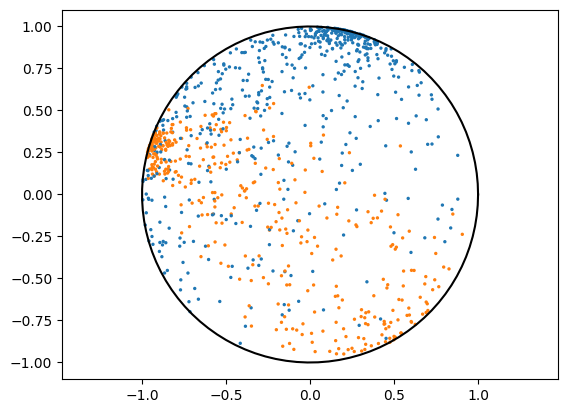

In [15]:
X, y = hyperbolic_pseudoproduct_manifold.gaussian_mixture(num_points=1000, num_classes=2)
_, X_poincare = hyperbolic_pseudoproduct_manifold.stereographic(X)

plt.scatter(
    X_poincare[:, 0].detach().numpy(), X_poincare[:, 1].detach().numpy(), c=y, s=2, cmap="tab10", vmin=0, vmax=10
)
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.show()

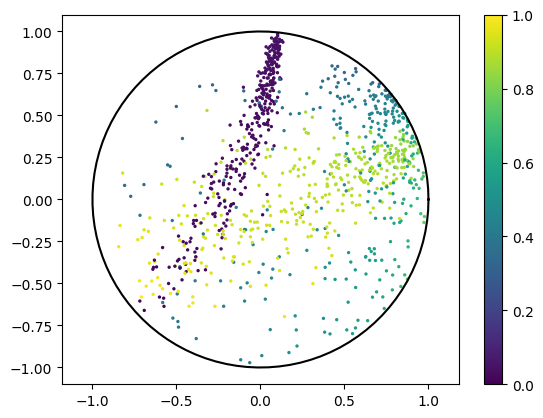

In [16]:
X, y = hyperbolic_pseudoproduct_manifold.gaussian_mixture(num_points=1000, num_classes=3, task="regression")
_, X_poincare = hyperbolic_pseudoproduct_manifold.stereographic(X)

plt.scatter(X_poincare[:, 0].detach().numpy(), X_poincare[:, 1].detach().numpy(), c=y, s=2, cmap="viridis")
plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), color="k")
plt.axis("equal")
plt.colorbar()
plt.show()

## Embedders

All embedders in Manify inherit from the `BaseEmbedder` class, which provides a common API for all embedders. All
embedders have the following methods:
* `fit`: Fit the embedder to the data.
* `transform`: Transform the data to the embedded space.
* `fit_transform`: Fit the embedder to the data and transform it in one go.

Not all embedders use the same data types, however! If you have pairwise distances, as you might e.g. when embedding a
graph, you can use the `CoordinateLearning` class; if you have features, you can use the `ProductSpaceVAE` class.
Finally, we have an experimental `SiameseNetwork` class that can use both pairwise distances and features to learn
embeddings.

### Coordinate Learning

Coordinate learning works when you have a matrix of pairwise distances of some sort. Let's use the `load_hf` utility to grab one of the graph datasets from our HuggingFace hub, and then embed it into plain old Euclidean space.

We will use 2D Euclidean space for visualization's sake, but feel free to change the signature - you might find that other signatures do a lot better for embedding these datasets.

In [17]:
_, polblogs_dists, _, polblogs_labels = utils.dataloaders.load_hf("polblogs")
print(polblogs_dists.shape)

torch.Size([1222, 1222])


Because we would like to distinguish between distances and features, the `fit` method of all embedders takes a matrix of features `X` and a matrix of pairwise distances `D`, in that order. Since the coordinate learning embedder does not use features, we can just pass `None` for the `X` argument. 

This syntax is slightly more verbose than simply passing the distance matrix as the only argument, but we believe it is worth it to maintain a consistent interface across all embedder types.

Let's train for 1,000 iterations total. On most computers this should take under a minute, achieving a final D_avg of 0.3438 (which is not very good, honestly, but we are interested more in demonstrations and visualizations than in actual performance here).

In [18]:
euclidean_manifold = manify.ProductManifold(signature=[(0.0, 2)])

coordinate_learning_embedder = manify.CoordinateLearning(pm=euclidean_manifold)
polblogs_embeddings = coordinate_learning_embedder.fit_transform(
    X=None, D=polblogs_dists, burn_in_iterations=100, training_iterations=900
)
print(polblogs_embeddings.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1222, 2])


The coordinate learning method learns a single set of coordinates, so we can use the `transform` method to get them. It does not require any arguments.

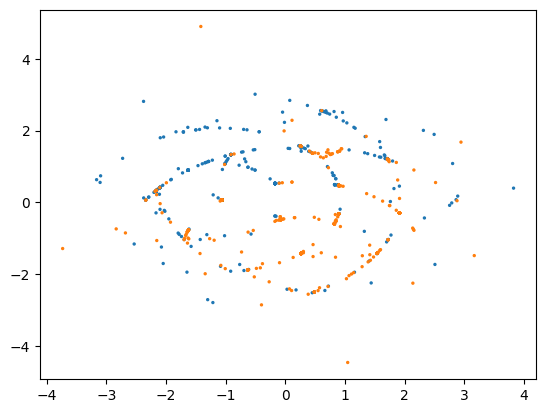

In [19]:
plt.scatter(
    polblogs_embeddings[:, 0].detach().numpy(),
    polblogs_embeddings[:, 1].detach().numpy(),
    c=polblogs_labels.numpy(),
    s=2,
    cmap="tab10",
    vmin=0,
    vmax=9,
)
plt.show()

You can also plot the loss history for all of your embedders like this. In this case, `train_train` refers to the distortion in the distances between elements of the training set and other elements of the training set; this is because `CoordinateLearning` supports non-transductive co-learning of train and test sets, wherein the gradient from the test set to the training set is masked out during training. 

For more details, consult the documentation of the `CoordinateLearning` class at [Manify's documentation](https://manify.readthedocs.io/en/latest/reference/embedders/coordinate_learning/).

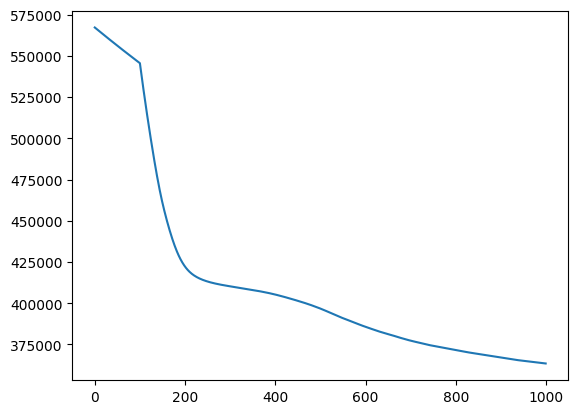

In [20]:
plt.plot(coordinate_learning_embedder.loss_history_["train_train"])
plt.show()

### Product Space VAE

In [21]:
mnist_features, _, _, mnist_labels = utils.dataloaders.load_hf("mnist")
print(mnist_features.shape)

torch.Size([60000, 28, 28])


The `ProductSpaceVAE` embedder requires an encoder and a decoder to be defined. The only constraints are:
* The input to the first layer of the encoder must be equal to the number of features in your data
* The output of the last layer of the decoder must be equal to TWICE the number of INTRINSIC dimensions in your product manifold (twice because we need to output both the mean and the log-variance of the latent space)
* The input to the first layer of the decoder must be equal to the number of EXTRINSIC (ambient) dimensions in your product manifold
* The output of the last layer of the encoder must be equal to the number of features in your data

The reason the encoder outputs intrisic dimensions, but the decoder takes extrinsic dimensions as input, has to do with the way that the VAE sampling occurs. For more details, consult the documentation of the `ProductSpaceVAE` class at [Manify's documentation](https://manify.readthedocs.io/en/latest/reference/embedders/vae/).

The following code should also run in under a minute on most computers.

In [22]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2 * euclidean_manifold.dim),  # The INTRINSIC dimension of the manifold
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(euclidean_manifold.ambient_dim, 128),  # The AMBIENT dimension of the manifold
    torch.nn.ReLU(),
    torch.nn.Linear(128, 784),
    torch.nn.Sigmoid(),
)


vae = manify.ProductSpaceVAE(pm=euclidean_manifold, encoder=encoder, decoder=decoder)

mnist_embeddings = vae.fit_transform(
    X=mnist_features.reshape(-1, 784), burn_in_iterations=1, training_iterations=9, batch_size=128
)
print(mnist_embeddings.shape)

  0%|          | 0/600000 [00:00<?, ?it/s]

torch.Size([60000, 2])


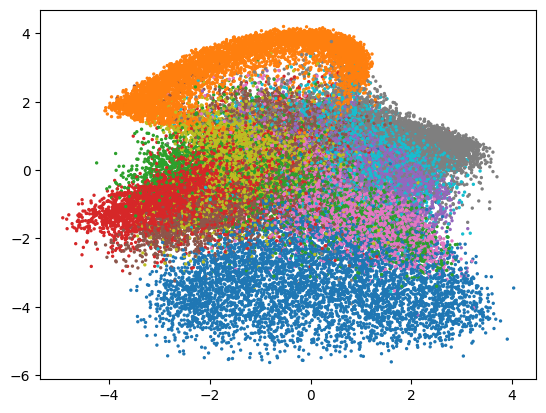

In [23]:
plt.scatter(
    mnist_embeddings[:, 0].detach().numpy(),
    mnist_embeddings[:, 1].detach().numpy(),
    c=mnist_labels.numpy(),
    s=2,
    cmap="tab10",
    vmin=0,
    vmax=9,
)
plt.show()

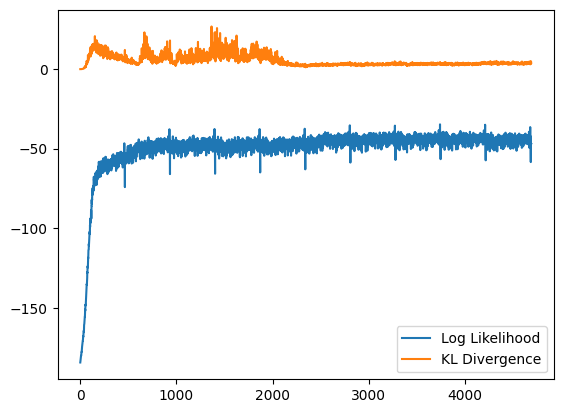

In [24]:
plt.plot(vae.loss_history_["ll"], label="Log Likelihood")
plt.plot(vae.loss_history_["kl"], label="KL Divergence")
plt.legend()
plt.show()

### Siamese Network

(**Note:** This is a fairly experimental embedder, and does not have an accompanying publication. We believe this might be useful in situations where you have both pairwise distances and features, but we haven't tested it extensively yet.)

In [25]:
qiita_features, qiita_dists, _, _ = utils.dataloaders.load_hf("qiita")
print(qiita_features.shape)

torch.Size([7000, 152])


This bit is a little slower, so we're just going to use 500 points for the tutorial:

In [26]:
SUBSAMPLE_QIITA = 500

encoder = torch.nn.Sequential(
    torch.nn.Linear(152, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, euclidean_manifold.dim),
)
decoder = torch.nn.Sequential(torch.nn.Linear(euclidean_manifold.ambient_dim, 64), torch.nn.Linear(64, 152))
siamese_net = manify.SiameseNetwork(pm=euclidean_manifold, encoder=encoder, decoder=decoder, random_state=42)
qiita_embeddings = siamese_net.fit_transform(
    X=qiita_features[:SUBSAMPLE_QIITA],
    D=qiita_dists[:SUBSAMPLE_QIITA, :SUBSAMPLE_QIITA],
    burn_in_iterations=1,
    training_iterations=9,
    batch_size=128,
)

  0%|          | 0/9750 [00:00<?, ?it/s]

We can color our embeddings on the basis of their true distance from some random point. We can see that even in two dimensions with very few iterations, the learned embeddings tend to preserve these distance relationships:

[]

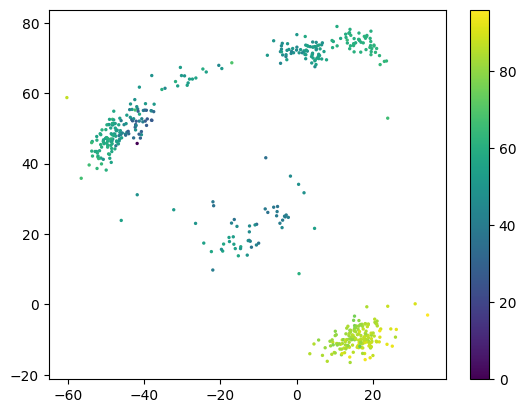

In [27]:
plt.scatter(
    qiita_embeddings[:, 0].detach().numpy(),
    qiita_embeddings[:, 1].detach().numpy(),
    c=qiita_dists[0, :SUBSAMPLE_QIITA].numpy(),
    s=2,
)
plt.colorbar()
plt.plot()

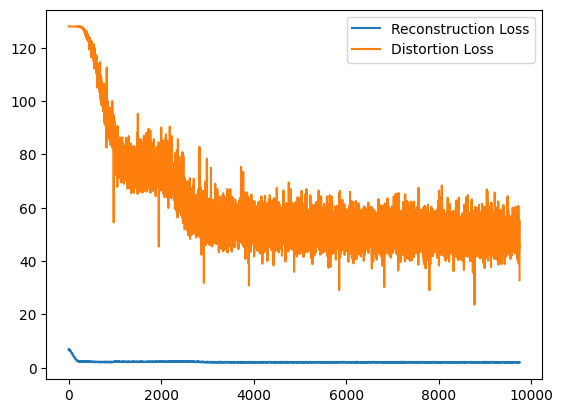

In [28]:
plt.plot(siamese_net.loss_history_["reconstruction"], label="Reconstruction Loss")
plt.plot(siamese_net.loss_history_["distortion"], label="Distortion Loss")
plt.legend()
plt.show()

## Predictors

Like the embedders, all predictors in Manify inherit from the `BasePredictor` class, but they are much more harmonious in terms of their API. All predictors are initialized with a reference to a product manifold (`pm`) and a `task` (`"classification"` or `"regression"`), and have the following methods:
* `fit`: Fit the predictor to the data.
* `predict`: Predict the target variable for the data.
* `fit_predict`: Fit the predictor to the data and predict the target variable in one go
* `score`: Compute the score of the predictor on the data.

Unlike the embedders, none of the predictors require exotic extra arguments for these methods, so they are quite straightforward to use.

### Classification

In [29]:
product_manifold = manify.ProductManifold(signature=[(-1.0, 2), (0.0, 2), (1.0, 2)])
X_classification, y_classification = product_manifold.gaussian_mixture(num_points=1000, num_classes=2, seed=2025)

(X_train_classification, X_test_classification, y_train_classification, y_test_classification) = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=2025
)

In [30]:
for model in [manify.ProductSpaceDT, manify.ProductSpaceRF, manify.ProductSpacePerceptron, manify.ProductSpaceSVM]:
    model_instance = model(pm=product_manifold, task="classification", random_state=2025)
    model_instance.fit(X_train_classification, y_train_classification)
    y_pred = model_instance.predict(X_test_classification)
    accuracy = model_instance.score(X_test_classification, y_test_classification)
    print(f"{model.__name__} Accuracy: {accuracy:.2f}")

ProductSpaceDT Accuracy: 0.90
ProductSpaceRF Accuracy: 0.94
ProductSpacePerceptron Accuracy: 0.45
ProductSpaceSVM Accuracy: 0.93


For $\kappa$-GCNs, we need to make four additional modifications:
1. We need to use a stereographic manifold
2. We need to pass the `output_dim` argument explicitly to the constructor
3. We need to pass in an adjacency matrix for the graph. Since we don't have one, we will use the `get_A_hat` function to compute it from a basic RBF kernel.
4. We need to set the learning rate to something reasonably stable, like `1e-4`:

In [31]:
# Convert product_manifold, X_train, and X_test to stereographic coordinates:
product_manifold_stereo, X_train_classification_stereo, X_test_classification_stereo = product_manifold.stereographic(
    X_train_classification, X_test_classification
)

# Get adjacency matrix
A_hat_train_classification = manify.predictors.kappa_gcn.get_A_hat(
    torch.exp(-product_manifold_stereo.pdist2(X_train_classification_stereo))
)
A_hat_test_classification = manify.predictors.kappa_gcn.get_A_hat(
    torch.exp(-product_manifold_stereo.pdist2(X_test_classification_stereo))
)

# This part is the same, except for how we construct the KappaGCN instance
kappa_gcn_instance = manify.KappaGCN(pm=product_manifold_stereo, task="classification", random_state=2025, output_dim=2)
kappa_gcn_instance.fit(X_train_classification_stereo, y_train_classification, lr=1e-4, A=A_hat_train_classification)
y_pred = kappa_gcn_instance.predict(X_test_classification_stereo, A=A_hat_test_classification)
accuracy = kappa_gcn_instance.score(X_test_classification_stereo, y_test_classification)
print(f"{kappa_gcn_instance.__class__.__name__} Accuracy: {accuracy:.2f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

KappaGCN Accuracy: 0.71


If you'd prefer to use a Kappa-MLP instead, which respects the geometry of the product manifold but does not do graph convolutions, you can simply pass `A=None` to the `fit` and `predict` methods (or leave it out entirely, since it defaults to `None`)

In [32]:
kappa_mlp_instance = manify.KappaGCN(pm=product_manifold_stereo, task="classification", random_state=2025, output_dim=2)
kappa_mlp_instance.fit(X_train_classification_stereo, y_train_classification, lr=1e-4, A=None)
y_pred = kappa_mlp_instance.predict(X_test_classification_stereo, A=None)
accuracy = kappa_mlp_instance.score(X_test_classification_stereo, y_test_classification)
print(f"KappaMLP Accuracy: {accuracy:.2f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

KappaMLP Accuracy: 0.71


Fun fact: $\kappa$-GCN models also store `loss_history_`, so we can plot that too. This one looks a little wonky, so maybe we should have played around more with the learning rate:

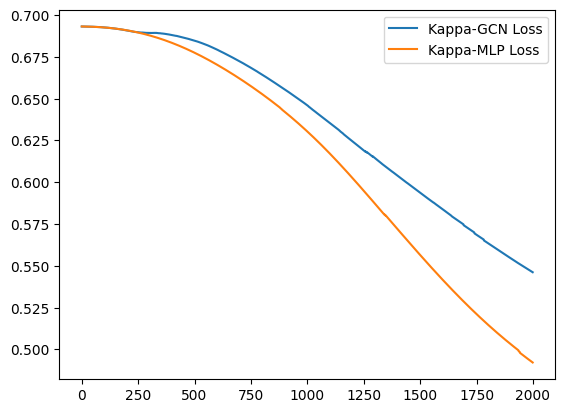

In [33]:
plt.plot(kappa_gcn_instance.loss_history_["train"], label="Kappa-GCN Loss")
plt.plot(kappa_mlp_instance.loss_history_["train"], label="Kappa-MLP Loss")
plt.legend()
plt.show()

### Regression

And just for kicks, let's repeat the same thing for regression. This isn't implemented for Perceptrons and SVMs yet (in fact, it's never been described at all in the literature), but we can use the other predictors just fine. Notice that `output_dim` must be set to 1 for the $\kappa$-GCN (although in theory you can do multioutput regression this way as well).

In [34]:
# Get the points again - this time as regression targets
X_regression, y_regression = product_manifold.gaussian_mixture(
    num_points=1000, num_classes=2, seed=2025, task="regression"
)
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=2025
)

# Re-benchmark DTs and RFs
for model in [manify.ProductSpaceDT, manify.ProductSpaceRF]:
    model_instance = model(pm=product_manifold, task="regression", random_state=2025)
    model_instance.fit(X_train_regression, y_train_regression)
    y_pred = model_instance.predict(X_test_regression)
    accuracy = model_instance.score(X_test_regression, y_test_regression)
    print(f"{model.__name__} MSE: {accuracy:.4f}")

# Repeat conversion to stereographic coordinates and KappaGCN fitting
product_manifold_stereo, X_train_regression_stereo, X_test_regression_stereo = product_manifold.stereographic(
    X_train_regression, X_test_regression
)

# Get adjacency matrix
A_hat_train_regression = manify.predictors.kappa_gcn.get_A_hat(
    torch.exp(-product_manifold_stereo.pdist2(X_train_regression_stereo))
)
A_hat_test_regression = manify.predictors.kappa_gcn.get_A_hat(
    torch.exp(-product_manifold_stereo.pdist2(X_test_regression_stereo))
)

# Evaluate Kappa-GCN
kappa_gcn_instance = manify.KappaGCN(pm=product_manifold_stereo, task="regression", random_state=2025, output_dim=1)
kappa_gcn_instance.fit(X_train_regression_stereo, y_train_regression, lr=1e-4, A=A_hat_train_regression)
y_pred = kappa_gcn_instance.predict(X_test_regression_stereo, A=A_hat_test_regression)
accuracy = kappa_gcn_instance.score(X_test_regression_stereo, y_test_regression)
print(f"{kappa_gcn_instance.__class__.__name__} MSE: {accuracy:.4f}")

# If you'd like to make a Kappa-MLP instead, simple use A=None:
kappa_mlp_instance = manify.KappaGCN(pm=product_manifold_stereo, task="regression", random_state=2025, output_dim=1)
kappa_mlp_instance.fit(X_train_regression_stereo, y_train_regression, lr=1e-4, A=None)
y_pred = kappa_mlp_instance.predict(X_test_regression_stereo, A=None)
accuracy = kappa_mlp_instance.score(X_test_regression_stereo, y_test_regression)
print(f"KappaMLP MSE: {accuracy:.4f}")

ProductSpaceDT MSE: 0.0280
ProductSpaceRF MSE: 0.0168


  0%|          | 0/2000 [00:00<?, ?it/s]

KappaGCN MSE: 0.0381


  0%|          | 0/2000 [00:00<?, ?it/s]

KappaMLP MSE: 0.0387


## End-to-end example (pipeline)

Now that we've seen all of the components, let's actually put together an end-to-end example. Here, we'll be embedding the Polblogs dataset from before into a product manifold, and classifying it using a product space decision tree.

(You may recognize this as the "Quick Example" subsection of the Github README, but we include it here for completeness.)

In [35]:
# Load Polblogs graph from HuggingFace
_, dists, _, labels = manify.utils.dataloaders.load_hf("polblogs")

# Create an S^4 x H^4 product manifold
pm = manify.ProductManifold(signature=[(1.0, 4), (-1.0, 4)])

# Get training indices - if we pass the test indices to the embedder, it will mask their gradients to the training data.
idx_train, idx_test, labels_train, labels_test = train_test_split(
    np.arange(len(labels)), labels, test_size=0.2, random_state=2025
)

# Learn embeddings (Gu et al (2018) method)
embedder = manify.CoordinateLearning(pm=pm)
X_embedded = embedder.fit_transform(
    X=None, D=dists, burn_in_iterations=200, training_iterations=800, test_indices=idx_test
)

# Train and evaluate classifier (Chlenski et al (2025) method)
X_train, X_test, y_train, y_test = train_test_split(X_embedded, labels)
model = manify.ProductSpaceDT(pm=pm, max_depth=3, task="classification")
model.fit(X_train, y_train)
print(f"Decision Tree accuracy on Polblogs classification: {model.score(X_test, y_test):.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Decision Tree accuracy on Polblogs classification: 0.92


In fact, since we've written our classes to be `scikit-learn` compatible where possible, we can even use the `Pipeline` class to chain together embedders and predictors, just as we would in a regular Euclidean scikit-learn workflow. 

In [36]:
# Get MNIST data again
MNIST_DOWNSAMPLE = 10_000
features, _, _, labels = manify.utils.dataloaders.load_hf("mnist")
X = features.reshape(-1, 784)[:MNIST_DOWNSAMPLE]
y = labels[:MNIST_DOWNSAMPLE]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# Get the product manifold - let's do a complicated one this time
# Note that we use a stereographic manifold here, which will make it automatically kappa-GCN compatible
pm = manify.ProductManifold(signature=[(0.0, 4), (1.0, 4), (1.0, 4)])


# Define the whole thing in one big pipeline!
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize the data first
        ("tensorizer", FunctionTransformer(lambda x: torch.tensor(x, dtype=torch.float32))),  # Convert back to torch
        (
            "vae_embedder",
            manify.ProductSpaceVAE(
                pm=pm,
                encoder=torch.nn.Sequential(
                    torch.nn.Linear(784, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 2 * pm.dim),
                ),
                decoder=torch.nn.Sequential(
                    torch.nn.Linear(pm.ambient_dim, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 784),
                    torch.nn.Sigmoid(),
                ),
                random_state=2025,
            ),
        ),
        (
            "kappa_gcn_classifier",
            manify.ProductSpaceDT(pm=pm),
        ),
    ]
)

# The pipeline exposes all of the same methods, so we can fit, predict, and score with it:
pipeline.fit(
    X_train,
    y_train,
    vae_embedder__burn_in_iterations=1,
    vae_embedder__training_iterations=9,
    vae_embedder__batch_size=128,
    vae_embedder__lr=1e-3,
)
y_pred = pipeline.predict(X_test)
accuracy = pipeline.score(X_test, y_test)
print(f"Pipeline accuracy: {accuracy:.2f}")

  0%|          | 0/80000 [00:00<?, ?it/s]

NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
Invalid loss detected at epoch 9, batch 1536
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
Invalid loss detected at epoch 9, batch 2688
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
Invalid loss detected at epoch 9, batch 3328
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
Invalid loss detected at epoch 9, batch 5248
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
NANs in parallel transport
Invalid loss detected at epoch 9, batch 5760
Pipeline accuracy: 0.52


# Curvature estimation
In a lot of cases, you might not know the curvature of your product manifold. For this, we have a `curvature_estimation` module that provides a couple of different functions for estimating te curvature of a product manifold. All curvature estimation methods are standalone functions, and do not inherit from any base class. Thus, we will treat each of them inidividually:

### δ-Hyperbolicity for Measuring Tree-Like Structure

When working with graph or network data, it's often valuable to understand how "tree-like" your data structure is. The `delta_hyperbolicity` function implements δ-hyperbolicity computation, which provides a quantitative measure of how close a metric space is to being a tree. This measure ranges from δ ≥ 0, where smaller values indicate more hyperbolic (tree-like) structure.

The method is based on the Gromov δ-hyperbolicity framework, which uses a four-point condition involving Gromov products to characterize the tree-like properties of metric spaces. For any four points in your space, it compares triangle geometries to determine how much they deviate from perfect tree structure.

This function offers three computational approaches to suit different needs and dataset sizes:

* **`sampled`**: Efficiently estimates δ-hyperbolicity by randomly sampling point triplets from your metric space. This approach scales well to large datasets while providing reliable estimates of the overall hyperbolicity.

* **`global`**: Computes the exact maximum δ value over all possible point triplets, giving you the precise δ-hyperbolicity of your entire space. This provides the most accurate measure but requires more computation.

* **`full`**: Returns the complete δ tensor over all triplets, allowing you to analyze the local variation in tree-like structure across different regions of your space.

Understanding the δ-hyperbolicity of your data can guide embedding choices: datasets with low δ values (more tree-like) are well-suited for hyperbolic embeddings, while higher δ values might suggest Euclidean or spherical spaces are more appropriate. This makes δ-hyperbolicity a valuable preprocessing step for determining optimal embedding geometries.

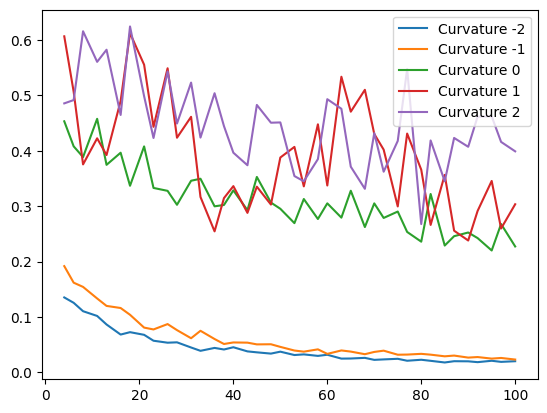

In [37]:
# Simple δ-hyperbolicity vs dimension for different curvatures
N = 50  # Number of points per sample
dims = [20, 40, 60, 80, 100]
dims = np.linspace(4, 100, 40, dtype=int).tolist()
curvatures = [-2, -1, 0, 1, 2]


for k in curvatures:
    delta_values = []
    for dim in dims:
        # Sample points and compute δ-hyperbolicity
        pm = manify.ProductManifold(signature=[(k, dim)])
        X = pm.sample(z_mean=torch.stack([pm.mu0] * N))
        dists = pm.pdist(X)
        delta = manify.curvature_estimation.delta_hyperbolicity(dists, method="global")
        delta_values.append(delta)

    plt.plot(dims, delta_values, label=f"Curvature {k}")

plt.legend()
plt.show()

### Sectional Curvature Estimation for Product Manifolds

When working with complex data that exhibits mixed geometric structures, determining the appropriate product manifold signature (the number and types of component spaces) can be challenging. The `sectional_curvature` function implements the discrete curvature estimation approach from Gu et al. (2019), which uses a triangle comparison theorem to estimate local curvature properties of graph data.

This method provides three different estimation approaches to suit various computational needs and use cases:

* **`sampled`**: Efficiently estimates curvature by randomly sampling triangle configurations from your graph. This approach scales well to large networks and provides a distribution of curvature estimates that can reveal the heterogeneous geometric structure of your data.

* **`per_node`**: Computes curvature estimates for each individual node by averaging over all valid triangles involving that node's neighbors. This gives you a fine-grained view of how curvature varies across different regions of your graph.

* **`global`**: Returns a single scalar representing the average curvature across the entire graph. This provides a quick summary statistic that can guide initial product manifold design decisions.

The underlying discrete curvature estimator compares triangle geometry to theoretical predictions: positive values suggest spherical-like (positively curved) regions, zero values indicate Euclidean (flat) regions, and negative values point to hyperbolic-like (negatively curved) regions. You can use these estimates to inform your choice of component spaces when constructing product manifolds, helping ensure that your embedding space geometry matches the intrinsic structure of your data.

In [38]:
# Load polblogs dataset - political blogs network
features, dists, adj_matrix, labels = manify.utils.dataloaders.load_hf("polblogs")
print(f"Polblogs network: {adj_matrix.shape[0]} nodes, {torch.sum(adj_matrix).item() // 2} edges")

# Convert to Numpy if needed
adj_dense = adj_matrix.numpy() if hasattr(adj_matrix, "numpy") else adj_matrix
dists_dense = dists.numpy() if hasattr(dists, "numpy") else dists

# Compute sectional curvature using sampled method (faster for larger graphs)
print("Computing sectional curvature (sampled method)...")
curvature_samples = manify.curvature_estimation.sectional_curvature(
    adjacency_matrix=torch.tensor(adj_dense, dtype=torch.float32),
    distance_matrix=torch.tensor(dists_dense, dtype=torch.float32),
    method="sampled",
    n_samples=1000,
)
curvature_mean = curvature_samples.mean().item()
print(f"Sectional curvature estimate (mean): {curvature_mean:.4f}")
print(f"Sectional curvature std: {curvature_samples.std().item():.4f}")

Polblogs network: 1222 nodes, 16775.0 edges
Computing sectional curvature (sampled method)...
Sectional curvature estimate (mean): 0.0236
Sectional curvature std: 0.0982


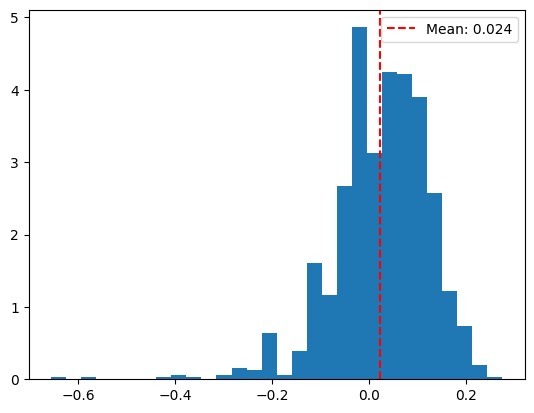

In [39]:
# Visualize the sectional curvature distribution
plt.hist(curvature_samples.numpy(), density=True, bins=30)
plt.axvline(
    curvature_samples.mean().item(),
    color="red",
    linestyle="--",
    label=f"Mean: {curvature_samples.mean().item():.3f}",
)
plt.legend()
plt.show()

### Greedy Near-Optimal Signature Selection

Sometimes you might be interested in finding the best signature for some sort of downstream task, or you might not have a reliable set of pairwise distances. For this, we have a `greedy_signature_selection` function that uses a greedy algorithm to find the best signature for a product manifold given a "pipeline," which is a flexible way to specify a function that takes in a product manifold, plus any additional arguments, and returns a scalar loss; the greedy algorithm will try to find the signature that minimizes this loss.

This is something of an advanced/experimental feature, but we do provide two pipelines in `manify.curvature_estimation._pipelines` to get you started. We recommend looking at the source code of these pipelines to understand what they do, and to model your own pipelines after them. The pipelines are:
* `distortion_pipeline`: Given a set of distances, use `CoordinateLearning` to embed them; return the distortion of the embedding relative to the original distances.
* `predictor_pipeline`: Given a set of distances and labels (as you might find in a graph dataset), use `CoordinateLearning` to embed them and return the classification/regression accuracy of a model from `manify.predictors` trained on the embedded data.

Iteration 1/3
  Trying component (-1.0, 2) (index 0)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (0.0, 2) (index 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (1.0, 2) (index 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  Accepted component (1.0, 2) with loss 4217289.5000
  Current signature: [(1.0, 2)]

Iteration 2/3
  Trying component (-1.0, 2) (index 0)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (0.0, 2) (index 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (1.0, 2) (index 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  Accepted component (1.0, 2) with loss 2109785.0000
  Current signature: [(1.0, 2), (1.0, 2)]

Iteration 3/3
  Trying component (-1.0, 2) (index 0)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (0.0, 2) (index 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (1.0, 2) (index 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  Accepted component (1.0, 2) with loss 1304594.2500
  Current signature: [(1.0, 2), (1.0, 2), (1.0, 2)]

[(1.0, 2), (1.0, 2), (1.0, 2)]


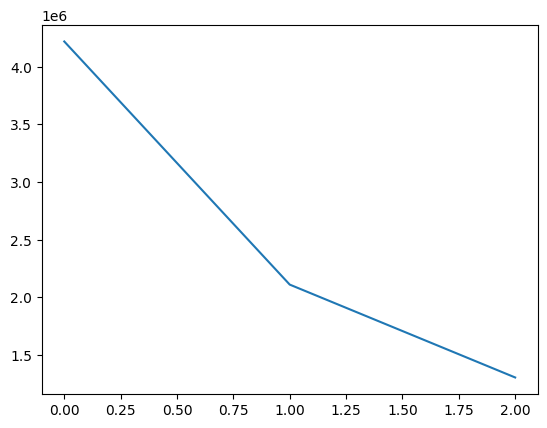

In [40]:
_, D, _, y = manify.utils.dataloaders.load_hf("polblogs")
D = D / D.max()

max_components = 3
embedder_init_kwargs = {"random_state": 42}
embedder_fit_kwargs = {"burn_in_iterations": 10, "training_iterations": 90, "lr": 1e-2}

# Try distortion pipeline
optimal_pm_distortion, loss_history_distortion = manify.greedy_signature_selection(
    pipeline=manify.curvature_estimation._pipelines.distortion_pipeline,
    dists=D,
    embedder_init_kwargs=embedder_init_kwargs,
    embedder_fit_kwargs=embedder_fit_kwargs,
    verbose=True,
)
print(optimal_pm_distortion.signature)
plt.plot(loss_history_distortion, label="Train Loss")

Iteration 1/3
  Trying component (-1.0, 2) (index 0)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (0.0, 2) (index 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (1.0, 2) (index 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  Accepted component (-1.0, 2) with loss -0.5392
  Current signature: [(-1.0, 2)]

Iteration 2/3
  Trying component (-1.0, 2) (index 0)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (0.0, 2) (index 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (1.0, 2) (index 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  Accepted component (-1.0, 2) with loss -0.6111
  Current signature: [(-1.0, 2), (-1.0, 2)]

Iteration 3/3
  Trying component (-1.0, 2) (index 0)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (0.0, 2) (index 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  Trying component (1.0, 2) (index 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  Accepted component (0.0, 2) with loss -0.6209
  Current signature: [(-1.0, 2), (-1.0, 2), (0.0, 2)]

[(-1.0, 2), (-1.0, 2), (0.0, 2)]


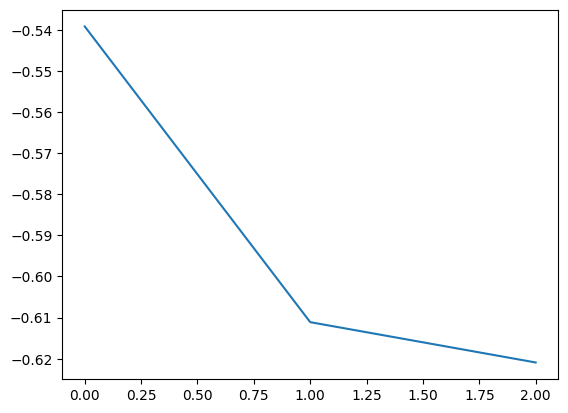

In [41]:
optimal_pm_classifier, loss_history_classifier = manify.greedy_signature_selection(
    pipeline=manify.curvature_estimation._pipelines.predictor_pipeline,
    labels=y,
    dists=D,
    embedder_init_kwargs=embedder_init_kwargs,
    embedder_fit_kwargs=embedder_fit_kwargs,
    verbose=True,
)
print(optimal_pm_classifier.signature)
plt.plot(loss_history_classifier, label="Train Loss")

# Clustering

The new `clustering` module supports clustering algorithms, also in a scikit-learn compatible way. At the moment, there is only one clustering algorithm implements (Riemannian Fuzzy K-Means), but as we add more in the future we will update the API to use a single base class as well.

For now, we will demonstrate the Riemannian Fuzzy K-Means algorithm's ability to accurately recover the clusters from a Gaussian mixture model on the product manifold. This is a very basic validation of the algorithm, but it should give you a sense of how to use it.

In [42]:
pm = manify.ProductManifold(signature=[(-1.0, 16), (0.0, 16), (1.0, 16)])

# Use classification labels, which identify clusters by their center
X_clustering, y_clustering = pm.gaussian_mixture(num_points=1000, num_classes=4, seed=2025, task="classification")

# The RFK algorithm is essentially a sklearn-styled clustering algorithm, so we call it like this:
rfk = manify.RiemannianFuzzyKMeans(pm=pm, n_clusters=4, random_state=2025)
rfk.fit(X_clustering)
y_pred = rfk.predict(X_clustering)
accuracy = (y_pred == y_clustering).float().mean().item()
print(f"Riemannian Fuzzy K-Means accuracy: {accuracy:.2f}")

Riemannian Fuzzy K-Means accuracy: 0.56
